#Leveraging Deep Learning for Multi-Class Classification of ECG Signals in Cardiac Health Monitoring

#Business Understanding

## Introduction

Cardiovascular diseases are a leading cause of mortality worldwide, and timely diagnosis is essential for effective treatment and improved patient outcomes. Electrocardiograms (ECGs) are a widely used and cost-effective diagnostic tool for detecting cardiac abnormalities, but their interpretation depends on specialized expertise that is often limited, particularly in resource-constrained healthcare settings. Recent advances in machine learning, combined with the availability of large, expertly annotated datasets such as PTB-XL, create an opportunity to automate ECG analysis and support clinicians with fast, consistent, and data-driven diagnostic insights.

##Problem Statement

Despite the widespread use of ECGs, limited access to cardiology specialists, delays in diagnosis, and variability in manual ECG interpretation create a need for an automated, reliable, and scalable ECG analysis system to support timely and consistent clinical decision-making.

## Main Objective

To develop a machine learning–based system capable of automatically analyzing 12-lead ECG signals and identifying cardiac abnormalities using the PTB-XL dataset in order to support clinical decision-making and improve diagnostic efficiency.

### Specific Objectives

1. To preprocess and analyze 12-lead ECG signals from the PTB-XL dataset for use in machine learning models.

2. To design and train supervised models for multi-label classification of clinically relevant ECG diagnostic categories.

3. To evaluate model performance using standard clinical metrics such as AUROC, F1-score, and sensitivity.

4. To assess the generalizability of the model across different patient groups and diagnostic classes.

5. To demonstrate the potential of the model as a clinical decision-support tool for healthcare and telemedicine applications.

# Data Understanding

## Data Source

The dataset used in this project is the PTB-XL electrocardiography (ECG) dataset, obtained from PhysioNet. PTB-XL is a large, publicly available collection of clinically validated 12-lead ECG recordings with comprehensive expert annotations. The dataset is released under an open-access license and is widely used for benchmarking ECG classification and analysis models.

## Data Description

PTB-XL contains approximately 21,800 12-lead ECG recordings collected from nearly 19,000 patients. Each recording is 10 seconds long and captured using a standard 12-lead configuration derived from 10 electrodes. The ECG signals are provided at two sampling frequencies: 500 Hz (high resolution) and 100 Hz (downsampled).

Each ECG record is accompanied by rich metadata, including patient demographics (such as age and sex), signal quality indicators, and detailed clinical annotations. The diagnostic labels are encoded using SCP-ECG statements, allowing each ECG to be associated with multiple diagnostic categories.

## Data Structure

The dataset consists of waveform files and metadata tables:

- Waveform files stored in WFDB format (.dat and .hea), containing raw ECG signals for 12 leads.

- ptbxl_database.csv, which links waveform files to metadata, patient information, and diagnostic annotations.

- scp_statements.csv, which provides descriptions and hierarchical groupings of the SCP-ECG diagnostic codes.

- The ECG signals are organized into folders based on sampling frequency, enabling flexibility in model design and computational efficiency.

## Data Labels and Target Variables

The primary target variables are the diagnostic ECG labels, represented as multi-label annotations. These labels are grouped into major diagnostic classes such as:

- Normal ECG

- Myocardial infarction

- ST/T changes

- Conduction disturbances

- Hypertrophy

Each ECG recording may belong to multiple diagnostic classes, making the task a multi-label classification problem.

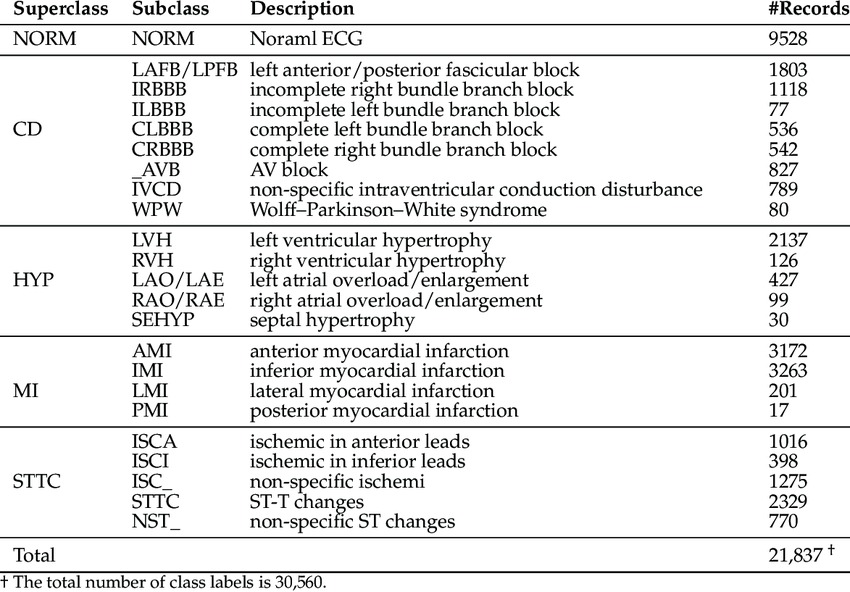

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")


In [1]:
!pip install wfdb


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to your zip file on Google Drive
zip_file_path = '/content/drive/MyDrive/ECG.zip'


In [4]:
import zipfile

# Specify the path to your zip file and the extraction destination
extract_to = '/content/ECG_Dataset'  # You can change this to another directory

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the files have been extracted
import os
print(os.listdir(extract_to))


['ECG']


In [5]:
import pandas as pd
import numpy as np
import wfdb
import ast

# Define path to the dataset
path = "/content/ECG_Dataset/ECG"
sampling_rate = 500

# Load metadata only (no signals yet)
Y = pd.read_csv(path + '/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Load scp_statements for diagnostic aggregation
agg_df = pd.read_csv(path + '/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic:
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Prepare metadata (no signals loaded yet)
biological_data = Y[['patient_id', 'age', 'sex', 'strat_fold', 'diagnostic_superclass']].copy()

# Add filename column for lazy loading
if sampling_rate == 100:
    biological_data['filename'] = Y['filename_lr']
else:
    biological_data['filename'] = Y['filename_hr']

print(f"Metadata prepared: {len(biological_data)} records")
print(biological_data.head())

# ===== OPTION 1: Generator for Lazy Loading =====
def load_signal_generator(df, path):
    """Generator that yields one signal at a time"""
    for idx, row in df.iterrows():
        signal, _ = wfdb.rdsamp(path + '/' + row['filename'])
        yield idx, signal

# Usage example:
# for ecg_id, signal in load_signal_generator(biological_data, path):
#     # Process one signal at a time
#     print(f"Processing ECG ID: {ecg_id}, Shape: {signal.shape}")
#     # Your processing code here
#     break  # Remove this to process all





Metadata prepared: 21837 records
        patient_id   age  sex  strat_fold diagnostic_superclass  \
ecg_id                                                            
1          15709.0  56.0    1           3                [NORM]   
2          13243.0  19.0    0           2                [NORM]   
3          20372.0  37.0    1           5                [NORM]   
4          17014.0  24.0    0           3                [NORM]   
5          17448.0  19.0    1           4                [NORM]   

                         filename  
ecg_id                             
1       records500/00000/00001_hr  
2       records500/00000/00002_hr  
3       records500/00000/00003_hr  
4       records500/00000/00004_hr  
5       records500/00000/00005_hr  


In [6]:
biological_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21837 entries, 1 to 21837
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21837 non-null  float64
 1   age                    21748 non-null  float64
 2   sex                    21837 non-null  int64  
 3   strat_fold             21837 non-null  int64  
 4   diagnostic_superclass  21837 non-null  object 
 5   filename               21837 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


##Data cleaning

In [7]:
biological_data.isnull().sum()

,0
patient_id,0
age,89
sex,0
strat_fold,0
diagnostic_superclass,0
filename,0


In [8]:
# Remove rows where 'age' is NaN
biological_data = biological_data.dropna(subset=["age"])

In [9]:
biological_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21748 entries, 1 to 21837
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             21748 non-null  float64
 1   age                    21748 non-null  float64
 2   sex                    21748 non-null  int64  
 3   strat_fold             21748 non-null  int64  
 4   diagnostic_superclass  21748 non-null  object 
 5   filename               21748 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [10]:
biological_data["age"].unique()

array([56., 19., 37., 24., 18., 54., 48., 55., 22., 20., 43., 58., 17.,
       49., 41., 25., 40., 60., 42., 28., 45., 51., 23., 59., 35., 30.,
       29., 26., 44., 31., 62., 21., 38., 27., 47., 46., 50., 64., 39.,
       33., 57., 68., 67., 52., 74., 80., 82., 81., 70., 36., 85., 77.,
       73., 72., 61., 66., 34., 53., 32., 84., 78., 83., 75., 79., 69.,
       63., 87., 76., 91., 71., 65., 90., 86., 88., 16., 89.,  3., 12.,
       14., 92., 93., 15., 94.,  9., 11., 13., 10.,  8., 95.,  2.,  5.,
        4.,  6.,  7.])

In [11]:
# Check if 'age' column exists and remove rows with NaN values in 'age'
if "age" in biological_data.columns:
    biological_data = biological_data.dropna(subset=["age"])  # Drop rows where 'age' is NaN

# Check the unique values of 'age' again to confirm NaNs have been removed
print(biological_data["age"].unique())


[56. 19. 37. 24. 18. 54. 48. 55. 22. 20. 43. 58. 17. 49. 41. 25. 40. 60.
 42. 28. 45. 51. 23. 59. 35. 30. 29. 26. 44. 31. 62. 21. 38. 27. 47. 46.
 50. 64. 39. 33. 57. 68. 67. 52. 74. 80. 82. 81. 70. 36. 85. 77. 73. 72.
 61. 66. 34. 53. 32. 84. 78. 83. 75. 79. 69. 63. 87. 76. 91. 71. 65. 90.
 86. 88. 16. 89.  3. 12. 14. 92. 93. 15. 94.  9. 11. 13. 10.  8. 95.  2.
  5.  4.  6.  7.]


In [12]:
biological_data["strat_fold"].unique()

array([ 3,  2,  5,  4,  7,  9, 10,  8,  6,  1])

In [13]:
# Strip any leading/trailing spaces in column names (in case of unexpected spaces)
biological_data.columns = biological_data.columns.str.strip()

# Check for duplicates in the 'patient_id' column
duplicate_count = biological_data["patient_id"].duplicated().sum()

print(f"Number of duplicate patient_id entries: {duplicate_count}")


Number of duplicate patient_id entries: 2945


In [14]:
duplicate_count = biological_data["filename"].duplicated().sum()
duplicate_count

np.int64(0)

In [15]:
# Drop duplicates based on 'patient_id', keeping the first occurrence
biological_data = biological_data.drop_duplicates(subset=["patient_id"], keep="first").reset_index(drop=True)

# Verify the result
print(f"Number of rows after dropping duplicates: {len(biological_data)}")


Number of rows after dropping duplicates: 18803


In [16]:
biological_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             18803 non-null  float64
 1   age                    18803 non-null  float64
 2   sex                    18803 non-null  int64  
 3   strat_fold             18803 non-null  int64  
 4   diagnostic_superclass  18803 non-null  object 
 5   filename               18803 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 881.5+ KB


In [17]:
biological_data["sex"].unique()

array([1, 0])

In [18]:
# Drop the 'patient_id' column from the DataFrame
#biological_data = biological_data.drop(columns=["patient_id"])

# Verify the result by printing the columns
print(biological_data.columns)


Index(['patient_id', 'age', 'sex', 'strat_fold', 'diagnostic_superclass',
       'filename'],
      dtype='object')


<Axes: >

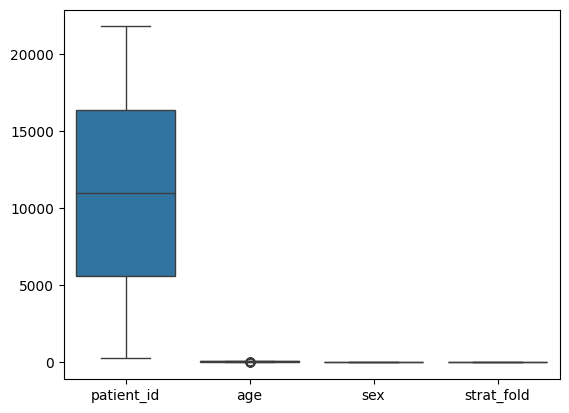

In [19]:
import seaborn as sns
sns.boxplot(biological_data)

<Axes: ylabel='age'>

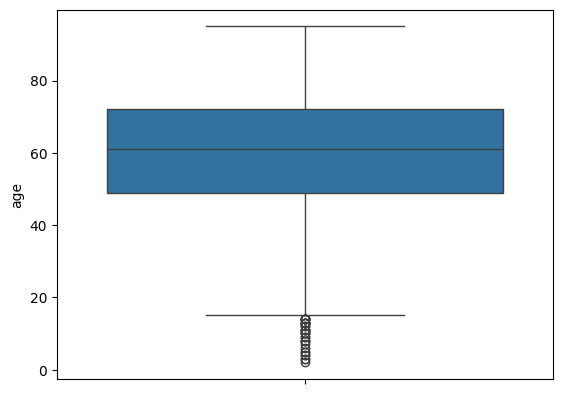

In [20]:
sns.boxplot(biological_data["age"])

In [21]:
import pandas as pd

# Calculate the 95th percentile of the 'age' column
age_95th_percentile = biological_data['age'].quantile(0.95)

# Remove rows where 'age' is greater than the 95th percentile
biological_data = biological_data[biological_data['age'] <= age_95th_percentile]

# Check the shape of the cleaned data
print(f"Data shape after removing outliers: {biological_data.shape}")


Data shape after removing outliers: (17883, 6)


In [22]:
biological_data["age"].max()

84.0

In [23]:
biological_data["age"].min()

2.0

In [24]:
# Check the structure of biological_data
print(biological_data.columns)  # List all columns
print(biological_data.head())  # Show the first few rows


Index(['patient_id', 'age', 'sex', 'strat_fold', 'diagnostic_superclass',
       'filename'],
      dtype='object')
   patient_id   age  sex  strat_fold diagnostic_superclass  \
0     15709.0  56.0    1           3                [NORM]   
1     13243.0  19.0    0           2                [NORM]   
2     20372.0  37.0    1           5                [NORM]   
3     17014.0  24.0    0           3                [NORM]   
4     17448.0  19.0    1           4                [NORM]   

                    filename  
0  records500/00000/00001_hr  
1  records500/00000/00002_hr  
2  records500/00000/00003_hr  
3  records500/00000/00004_hr  
4  records500/00000/00005_hr  


##Preprocessing

#### Flatten the diagnostic_superclass column
- The diagnostic_superclass column should not be in a list.
- We need to flatten this column so that each entry is a single string rather than a list.
- We can use .apply() to extract the first element from each list

In [25]:
# Flatten the 'diagnostic_superclass' column to make it a single value instead of a list
# Handle empty lists gracefully by setting them to None or a default value
biological_data['diagnostic_superclass'] = biological_data['diagnostic_superclass'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
)

# Verify the result
print(biological_data['diagnostic_superclass'].head())

print(biological_data.head())

0    NORM
1    NORM
2    NORM
3    NORM
4    NORM
Name: diagnostic_superclass, dtype: object
   patient_id   age  sex  strat_fold diagnostic_superclass  \
0     15709.0  56.0    1           3                  NORM   
1     13243.0  19.0    0           2                  NORM   
2     20372.0  37.0    1           5                  NORM   
3     17014.0  24.0    0           3                  NORM   
4     17448.0  19.0    1           4                  NORM   

                    filename  
0  records500/00000/00001_hr  
1  records500/00000/00002_hr  
2  records500/00000/00003_hr  
3  records500/00000/00004_hr  
4  records500/00000/00005_hr  


In [26]:
biological_data['diagnostic_superclass'].head(20)

,diagnostic_superclass
0,NORM
1,NORM
2,NORM
3,NORM
4,NORM
5,NORM
6,NORM
7,MI
8,NORM
9,NORM


In [27]:
biological_data.head()

,patient_id,age,sex,strat_fold,diagnostic_superclass,filename
0,15709.0,56.0,1,3,NORM,records500/00000/00001_hr
1,13243.0,19.0,0,2,NORM,records500/00000/00002_hr
2,20372.0,37.0,1,5,NORM,records500/00000/00003_hr
3,17014.0,24.0,0,3,NORM,records500/00000/00004_hr
4,17448.0,19.0,1,4,NORM,records500/00000/00005_hr


#### Feature Engineering: (extracting statistical features from the ECG signal)

We'll extract basic statistics (mean, standard deviation, range) from the raw ECG signals.

In [28]:
# 1. Remove rows where 'diagnostic_superclass' is None from biological data
biological_data = biological_data[['patient_id','age', 'strat_fold', 'sex', 'filename', 'diagnostic_superclass']].dropna(subset=['diagnostic_superclass'])

# 2. Extract the target variable (diagnostic_superclass) and encode it
y = biological_data['diagnostic_superclass'].values

# # Function to extract signal features (if needed, or just reshape for LSTM)
# def extract_signal_features(signal):
#     # Here, we assume each signal is a time series of 1D ECG data (univariate signal)
#     # You can pad the signals to the same length (e.g., 500 samples)
#     signal = np.pad(signal, (0, 500 - len(signal)), 'constant') if len(signal) < 500 else signal[:500]
#     return signal

#### label Encoding

In [29]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode the labels

In [30]:
biological_data.head()

,patient_id,age,strat_fold,sex,filename,diagnostic_superclass
0,15709.0,56.0,3,1,records500/00000/00001_hr,NORM
1,13243.0,19.0,2,0,records500/00000/00002_hr,NORM
2,20372.0,37.0,5,1,records500/00000/00003_hr,NORM
3,17014.0,24.0,3,0,records500/00000/00004_hr,NORM
4,17448.0,19.0,4,1,records500/00000/00005_hr,NORM


In [31]:
# Save the dataset to a Pickle file
biological_data.to_csv('biological_data.csv', index=False)

print("Dataset saved as biological_data.csv")


Dataset saved as biological_data.csv


In [32]:
import pandas as pd
# Load the dataset from the Pickle file
biological_data = pd.read_csv('biological_data.csv')

# Display the first few rows to verify it's loaded correctly
print(biological_data.head())


   patient_id   age  strat_fold  sex                   filename  \
0     15709.0  56.0           3    1  records500/00000/00001_hr   
1     13243.0  19.0           2    0  records500/00000/00002_hr   
2     20372.0  37.0           5    1  records500/00000/00003_hr   
3     17014.0  24.0           3    0  records500/00000/00004_hr   
4     17448.0  19.0           4    1  records500/00000/00005_hr   

  diagnostic_superclass  
0                  NORM  
1                  NORM  
2                  NORM  
3                  NORM  
4                  NORM  


In [33]:
import os
import pandas as pd
import numpy as np
import wfdb

CSV_PATH = "biological_data.csv"

# IMPORTANT: this should be the folder that contains "records500/"
PTBXL_ROOT = "/content/ECG_Dataset/ECG"

df = pd.read_csv(CSV_PATH)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

required = ["filename", "age", "sex", "diagnostic_superclass"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"CSV missing columns: {missing}")

def wfdb_basepath(relpath: str) -> str:
    # relpath in your CSV already starts with "records500/..."
    return os.path.join(PTBXL_ROOT, relpath)

# 1) File existence check
missing_files = []
for i, rel in enumerate(df["filename"].astype(str)):
    bp = wfdb_basepath(rel)
    if not (os.path.exists(bp + ".hea") and os.path.exists(bp + ".dat")):
        missing_files.append((i, rel, bp))

print(f"Rows in CSV: {len(df)}")
print(f"Missing WFDB pairs (.hea/.dat): {len(missing_files)}")

# 2) Load a few records
def check_one(i):
    bp = wfdb_basepath(df.loc[i, "filename"])
    sig, meta = wfdb.rdsamp(bp)
    return {
        "row": i,
        "filename": df.loc[i, "filename"],
        "basepath": bp,
        "sig_shape": sig.shape,          # expect (5000, 12) for 500 Hz
        "fs": meta.get("fs", None),      # expect 500
        "n_sig": meta.get("n_sig", None),
        "sig_name": meta.get("sig_name", None),
    }

rng = np.random.default_rng(0)
sample_idx = rng.choice(len(df), size=min(10, len(df)), replace=False)

results, failures = [], []
for i in sample_idx:
    try:
        results.append(check_one(int(i)))
    except Exception as e:
        failures.append((int(i), df.loc[int(i), "filename"], str(e)))

print("\nLoaded sample records successfully:")
for r in results:
    print(r)

print("\nFailures (if any):")
for f in failures:
    print(f)


Rows in CSV: 17630
Missing WFDB pairs (.hea/.dat): 0

Loaded sample records successfully:
{'row': 14988, 'filename': 'records500/18000/18277_hr', 'basepath': '/content/ECG_Dataset/ECG/records500/18000/18277_hr', 'sig_shape': (5000, 12), 'fs': 500, 'n_sig': 12, 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']}
{'row': 14337, 'filename': 'records500/17000/17519_hr', 'basepath': '/content/ECG_Dataset/ECG/records500/17000/17519_hr', 'sig_shape': (5000, 12), 'fs': 500, 'n_sig': 12, 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']}
{'row': 11224, 'filename': 'records500/13000/13593_hr', 'basepath': '/content/ECG_Dataset/ECG/records500/13000/13593_hr', 'sig_shape': (5000, 12), 'fs': 500, 'n_sig': 12, 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']}
{'row': 9007, 'filename': 'records500/10000/10803_hr', 'basepath': '/content/ECG_Dataset/ECG/records500/10000/10803_hr', 'sig_shap

In [34]:
import pandas as pd

df = pd.read_csv("biological_data.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

if "strat_fold" not in df.columns:
    raise ValueError("No strat_fold column found. If you want, I can show a random split instead.")

test_fold = 10
val_fold = 9

train_df = df[(df.strat_fold != test_fold) & (df.strat_fold != val_fold)].reset_index(drop=True)
val_df   = df[df.strat_fold == val_fold].reset_index(drop=True)
test_df  = df[df.strat_fold == test_fold].reset_index(drop=True)

print("train/val/test:", len(train_df), len(val_df), len(test_df))
print("classes:", sorted(df["diagnostic_superclass"].unique()))


train/val/test: 14051 1812 1767
classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']


In [35]:
print(df["diagnostic_superclass"].head(20).tolist())


['NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'MI', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'STTC', 'NORM']


In [36]:
import os
import pandas as pd
import numpy as np
import wfdb
import torch
from torch.utils.data import Dataset, DataLoader

# Load the metadata from the CSV (remove index_col parameter if patient_id causes issues)
df = pd.read_csv("/content/ECG_Dataset/ECG/biological_data.csv")

# Create a label mapping
classes = sorted(df["diagnostic_superclass"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

# Print the class mapping to confirm
print(f"\nClass mapping: {class_to_idx}")

# ============================================================
# STEP 1: Dataset Class
# ============================================================
class PTBXLRawMultiClass(Dataset):
    def __init__(self, sub_df, root, class_to_idx):
        self.df = sub_df.reset_index(drop=True)  # Reset index for clean iloc access
        self.root = root
        self.class_to_idx = class_to_idx

        # Normalize age based on training set
        self.age_mean = float(self.df["age"].mean())
        self.age_std = float(self.df["age"].std() + 1e-8)

    def set_age_stats(self, mean, std):
        self.age_mean = float(mean)
        self.age_std = float(std + 1e-8)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load raw ECG signal (5000, 12) for 500Hz data
        bp = os.path.join(self.root, row["filename"])
        sig, meta = wfdb.rdsamp(bp)
        sig = sig.astype("float32")
        x_sig = torch.from_numpy(sig)  # (T,C) where T=5000, C=12

        # Demographics
        age = float(row["age"])
        sex = float(row["sex"])  # Assuming sex is 0/1 encoded
        age = (age - self.age_mean) / self.age_std
        x_demo = torch.tensor([age, sex], dtype=torch.float32)  # (2,)

        # Label (integer index)
        y = self.class_to_idx[row["diagnostic_superclass"]]
        y = torch.tensor(y, dtype=torch.long)

        return x_sig, x_demo, y

# ============================================================
# STEP 2: Create datasets and dataloaders
# ============================================================
def collate_fn(batch):
    xs, xd, y = zip(*batch)
    xs = torch.stack(xs, dim=0)   # (B,T,C) = (B,5000,12)
    xd = torch.stack(xd, dim=0)   # (B,2)
    y = torch.stack(y, dim=0)     # (B,)
    return xs, xd, y

# Create datasets
PTBXL_ROOT = "/content/ECG_Dataset/ECG"  # path to the ECG data
train_ds = PTBXLRawMultiClass(train_df, PTBXL_ROOT, class_to_idx)
val_ds   = PTBXLRawMultiClass(val_df, PTBXL_ROOT, class_to_idx)
test_ds  = PTBXLRawMultiClass(test_df, PTBXL_ROOT, class_to_idx)

# Use TRAIN age stats for val/test normalization
train_age_mean = train_df["age"].mean()
train_age_std  = train_df["age"].std()

val_ds.set_age_stats(train_age_mean, train_age_std)
test_ds.set_age_stats(train_age_mean, train_age_std)

# Create DataLoader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

# ============================================================
# STEP 3: Smoke Test
# ============================================================
xs, xd, y = next(iter(train_dl))
print(f"\nBatch shapes:")
print(f"  ECG signals (xs): {xs.shape}")  # (16, 5000, 12)
print(f"  Demographics (xd): {xd.shape}")  # (16, 2)
print(f"  Labels (y): {y.shape}")          # (16,)

print(f"\nSample demographics (first batch):")
print(f"  Age (normalized): {xd[0, 0]:.2f}")
print(f"  Sex: {xd[0, 1]:.0f}")
print(f"  Label: {y[0].item()} ({idx_to_class[y[0].item()]})")

print(f"\nDataset ready! Memory-efficient loading confirmed ✓")


Class mapping: {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}

Batch shapes:
  ECG signals (xs): torch.Size([16, 5000, 12])
  Demographics (xd): torch.Size([16, 2])
  Labels (y): torch.Size([16])

Sample demographics (first batch):
  Age (normalized): -1.21
  Sex: 1
  Label: 3 (NORM)

Dataset ready! Memory-efficient loading confirmed ✓


In [40]:
from torch.utils.data import WeightedRandomSampler

# Recompute the class frequencies in the training dataset
train_class_counts = train_df['diagnostic_superclass'].value_counts()

# Compute class weights as inverse of class frequency with smoothing to avoid extreme weights
smoothing_factor = 1e-3  # Small constant to prevent extreme weights
class_weights = 1.0 / (train_class_counts + smoothing_factor)

# Apply a scaling factor to increase the weight for underrepresented classes
scaling_factor = 3.5  # Adjust this factor to increase weight for minority classes
class_weights = class_weights * scaling_factor

# Normalize the weights to ensure the sum is proportional to the dataset size
class_weights = class_weights / class_weights.sum() * len(train_class_counts)

# Create a dictionary mapping each class NAME (string) to its weight
class_weights_dict = {cls_name: class_weights[cls_name] for cls_name in class_weights.index}
print(f"Adjusted Class weights: {class_weights_dict}")

# Now, compute sample weights based on the adjusted class weights
train_labels_str = train_df['diagnostic_superclass'].values  # Get class names directly

# Calculate sample weights based on the class weights
sample_weights = np.array([class_weights_dict[label] for label in train_labels_str])

# Create a WeightedRandomSampler with the adjusted weights
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True  # Resample with replacement to handle imbalance
)

# Create a new DataLoader that uses the sampler
train_dl = DataLoader(
    train_ds,
    batch_size=16,
    sampler=sampler,  # Use the sampler here instead of shuffle
    num_workers=2,
    pin_memory=True,
    collate_fn=collate_fn
)

# Verify if the DataLoader is working by inspecting a batch
xs, xd, y = next(iter(train_dl))
print(f"\nBatch shapes (after weighted sampling):")
print(f"  ECG signals (xs): {xs.shape}")  # (16, 5000, 12)
print(f"  Demographics (xd): {xd.shape}")  # (16, 2)
print(f"  Labels (y): {y.shape}")          # (16,)

Adjusted Class weights: {'NORM': np.float64(0.29055628396025057), 'MI': np.float64(0.7405653435633379), 'STTC': np.float64(1.12429733842221), 'HYP': np.float64(1.3358136876490794), 'CD': np.float64(1.5087673464051223)}

Batch shapes (after weighted sampling):
  ECG signals (xs): torch.Size([16, 5000, 12])
  Demographics (xd): torch.Size([16, 2])
  Labels (y): torch.Size([16])


In [41]:
print(f"Class weights used: {class_weights_dict}")


Class weights used: {'NORM': np.float64(0.29055628396025057), 'MI': np.float64(0.7405653435633379), 'STTC': np.float64(1.12429733842221), 'HYP': np.float64(1.3358136876490794), 'CD': np.float64(1.5087673464051223)}


In [42]:
# Get a batch from the DataLoader
xs, xd, y = next(iter(train_dl))  # This gives you a batch

# Check the distribution of labels in this batch
print(f"Label distribution in the batch: {torch.bincount(y)}")


Label distribution in the batch: tensor([3, 3, 3, 4, 3])


##Modeling

In [48]:
import torch
import torch.nn as nn

class CNN1DAttentionEcgNet(nn.Module):
    def __init__(self, num_classes=5, hidden_size=128, dropout_rate=0.3):
        super(CNN1DAttentionEcgNet, self).__init__()

        # Multi-scale 1D CNN for ECG feature extraction
        # Branch 1: Small receptive field
        self.conv1_1 = nn.Conv1d(12, 64, kernel_size=7, padding=3)
        self.bn1_1 = nn.BatchNorm1d(64)
        self.conv1_2 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.bn1_2 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Branch 2: Medium receptive field
        self.conv2_1 = nn.Conv1d(12, 64, kernel_size=15, padding=7)
        self.bn2_1 = nn.BatchNorm1d(64)
        self.conv2_2 = nn.Conv1d(64, 64, kernel_size=15, padding=7)
        self.bn2_2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Branch 3: Large receptive field
        self.conv3_1 = nn.Conv1d(12, 64, kernel_size=31, padding=15)
        self.bn3_1 = nn.BatchNorm1d(64)
        self.conv3_2 = nn.Conv1d(64, 64, kernel_size=31, padding=15)
        self.bn3_2 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Combine multi-scale features
        self.conv_merge = nn.Conv1d(192, 128, kernel_size=3, padding=1)
        self.bn_merge = nn.BatchNorm1d(128)
        self.pool_merge = nn.MaxPool1d(kernel_size=2)
        self.dropout_merge = nn.Dropout(dropout_rate)

        # Additional conv layers
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=2)
        self.dropout4 = nn.Dropout(dropout_rate)

        # Attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8, dropout=dropout_rate, batch_first=True)

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Demographic processing
        self.fc_demo = nn.Linear(2, 64)
        self.bn_demo = nn.BatchNorm1d(64)
        self.dropout_demo = nn.Dropout(dropout_rate)

        # Classification head with more dropout
        self.fc1 = nn.Linear(256 + 64, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout_fc2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x_ecg, x_demo):
        # x_ecg: (B, T, C) -> transpose to (B, C, T)
        x = x_ecg.transpose(1, 2)

        # Multi-scale feature extraction with BatchNorm and Dropout
        # Branch 1
        x1 = torch.relu(self.bn1_1(self.conv1_1(x)))
        x1 = torch.relu(self.bn1_2(self.conv1_2(x1)))
        x1 = self.pool1(x1)
        x1 = self.dropout1(x1)

        # Branch 2
        x2 = torch.relu(self.bn2_1(self.conv2_1(x)))
        x2 = torch.relu(self.bn2_2(self.conv2_2(x2)))
        x2 = self.pool2(x2)
        x2 = self.dropout2(x2)

        # Branch 3
        x3 = torch.relu(self.bn3_1(self.conv3_1(x)))
        x3 = torch.relu(self.bn3_2(self.conv3_2(x3)))
        x3 = self.pool3(x3)
        x3 = self.dropout3(x3)

        # Concatenate multi-scale features
        x = torch.cat([x1, x2, x3], dim=1)

        # Merge and reduce
        x = torch.relu(self.bn_merge(self.conv_merge(x)))
        x = self.pool_merge(x)
        x = self.dropout_merge(x)

        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Attention mechanism
        x = x.transpose(1, 2)
        x_attn, _ = self.attention(x, x, x)
        x = x + x_attn

        # Global pooling
        x = x.transpose(1, 2)
        x = self.global_pool(x).squeeze(-1)

        # Demographic features
        demo_out = torch.relu(self.bn_demo(self.fc_demo(x_demo)))
        demo_out = self.dropout_demo(demo_out)

        # Combine
        combined = torch.cat([x, demo_out], dim=1)

        # Classification with BatchNorm
        x = torch.relu(self.bn_fc1(self.fc1(combined)))
        x = self.dropout_fc1(x)
        x = torch.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        x = self.fc3(x)

        return x

# Initialize improved model
model = CNN1DAttentionEcgNet(num_classes=5, hidden_size=128, dropout_rate=0.3).to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

CNN1DAttentionEcgNet(
  (conv1_1): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2_1): Conv1d(12, 64, kernel_size=(15,), stride=(1,), padding=(7,))
  (bn2_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv1d(64, 64, kernel_size=(15,), stride=(1,), padding=(7,))
  (bn2_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3_1): Conv1d(12, 64, kernel_size=(31,), stride=(1,), 

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Better optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop with validation
epochs = 50
best_val_acc = 0.0

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for xs, xd, y in train_dl:
        xs, xd, y = xs.to(device), xd.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(xs, xd)
        loss = criterion(logits, y)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xs, xd, y in val_dl:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)
            logits = model(xs, xd)
            loss = criterion(logits, y)

            val_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f}")

    # Print if learning rate changed
    if new_lr != current_lr:
        print(f"  → Learning rate reduced to {new_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ New best model saved! Val Acc: {val_acc:.4f}")

    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds,
                                    target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.4f}")

Epoch 1/50 | Train Loss: 1.3342, Train Acc: 0.4479 | Val Loss: 0.9920, Val Acc: 0.6291 | LR: 0.001000
  ✓ New best model saved! Val Acc: 0.6291
Epoch 2/50 | Train Loss: 1.1714, Train Acc: 0.5536 | Val Loss: 1.0761, Val Acc: 0.5806 | LR: 0.001000
Epoch 3/50 | Train Loss: 1.1099, Train Acc: 0.5864 | Val Loss: 0.9718, Val Acc: 0.6308 | LR: 0.001000
  ✓ New best model saved! Val Acc: 0.6308
Epoch 4/50 | Train Loss: 1.0781, Train Acc: 0.5959 | Val Loss: 0.9362, Val Acc: 0.6545 | LR: 0.001000
  ✓ New best model saved! Val Acc: 0.6545
Epoch 5/50 | Train Loss: 1.0440, Train Acc: 0.6168 | Val Loss: 0.9566, Val Acc: 0.6374 | LR: 0.001000
Epoch 6/50 | Train Loss: 1.0326, Train Acc: 0.6207 | Val Loss: 0.8592, Val Acc: 0.6799 | LR: 0.001000
  ✓ New best model saved! Val Acc: 0.6799
Epoch 7/50 | Train Loss: 1.0241, Train Acc: 0.6212 | Val Loss: 1.0202, Val Acc: 0.6120 | LR: 0.001000
Epoch 8/50 | Train Loss: 0.9983, Train Acc: 0.6369 | Val Loss: 0.9280, Val Acc: 0.6518 | LR: 0.001000
Epoch 9/50 | Tra

### Lets try data augmentation

In [50]:
import torch
import numpy as np
import os
import wfdb
from torch.utils.data import Dataset, DataLoader

class ECGAugmentation:
    """Apply realistic augmentations to ECG signals"""

    @staticmethod
    def add_gaussian_noise(signal, std=0.05):
        """Add Gaussian noise to simulate sensor noise"""
        noise = torch.randn_like(signal) * std
        return signal + noise

    @staticmethod
    def scale_amplitude(signal, scale_range=(0.9, 1.1)):
        """Scale amplitude to simulate patient variability"""
        scale = torch.FloatTensor(1).uniform_(*scale_range).item()
        return signal * scale

    @staticmethod
    def time_shift(signal, max_shift=50):
        """Shift signal in time"""
        shift = np.random.randint(-max_shift, max_shift)
        if shift > 0:
            return torch.cat([signal[shift:], signal[:shift]], dim=0)
        elif shift < 0:
            return torch.cat([signal[shift:], signal[:shift]], dim=0)
        return signal

    @staticmethod
    def baseline_wander(signal, amplitude=0.05, frequency=0.5):
        """Add baseline wander to simulate breathing artifacts"""
        t = torch.linspace(0, 2*np.pi*frequency, signal.shape[0])
        wander = amplitude * torch.sin(t).unsqueeze(1)
        return signal + wander

# Updated Dataset class with augmentation
class PTBXLRawMultiClass(Dataset):
    def __init__(self, sub_df, root, class_to_idx, augment=False):
        self.df = sub_df.reset_index(drop=True)
        self.root = root
        self.class_to_idx = class_to_idx
        self.augment = augment
        self.aug = ECGAugmentation()

        self.age_mean = float(self.df["age"].mean())
        self.age_std = float(self.df["age"].std() + 1e-8)

    def set_age_stats(self, mean, std):
        self.age_mean = float(mean)
        self.age_std = float(std + 1e-8)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        bp = os.path.join(self.root, row["filename"])
        sig, meta = wfdb.rdsamp(bp)
        sig = sig.astype("float32")
        x_sig = torch.from_numpy(sig)

        # Apply augmentation during training (50% chance for each augmentation)
        if self.augment:
            if np.random.rand() > 0.5:
                x_sig = self.aug.add_gaussian_noise(x_sig, std=0.03)
            if np.random.rand() > 0.5:
                x_sig = self.aug.scale_amplitude(x_sig, scale_range=(0.95, 1.05))
            if np.random.rand() > 0.5:
                x_sig = self.aug.baseline_wander(x_sig, amplitude=0.02)

        # Demographics
        age = float(row["age"])
        sex = float(row["sex"])
        age = (age - self.age_mean) / self.age_std
        x_demo = torch.tensor([age, sex], dtype=torch.float32)

        # Label
        y = self.class_to_idx[row["diagnostic_superclass"]]
        y = torch.tensor(y, dtype=torch.long)

        return x_sig, x_demo, y

# Recreate datasets with augmentation enabled for training
PTBXL_ROOT = "/content/ECG_Dataset/ECG"
train_ds = PTBXLRawMultiClass(train_df, PTBXL_ROOT, class_to_idx, augment=True)  # Enable augmentation
val_ds   = PTBXLRawMultiClass(val_df, PTBXL_ROOT, class_to_idx, augment=False)   # No augmentation for validation
test_ds  = PTBXLRawMultiClass(test_df, PTBXL_ROOT, class_to_idx, augment=False)  # No augmentation for test

# Use TRAIN age stats for val/test normalization
train_age_mean = train_df["age"].mean()
train_age_std  = train_df["age"].std()

val_ds.set_age_stats(train_age_mean, train_age_std)
test_ds.set_age_stats(train_age_mean, train_age_std)

print("✓ Datasets created with augmentation enabled for training")

✓ Datasets created with augmentation enabled for training


In [51]:
from torch.utils.data import WeightedRandomSampler

# Recompute the class frequencies in the training dataset
train_class_counts = train_df['diagnostic_superclass'].value_counts()

# Compute class weights
smoothing_factor = 1e-3
class_weights = 1.0 / (train_class_counts + smoothing_factor)
scaling_factor = 2.5
class_weights = class_weights * scaling_factor
class_weights = class_weights / class_weights.sum() * len(train_class_counts)

class_weights_dict = {cls_name: class_weights[cls_name] for cls_name in class_weights.index}
print(f"Adjusted Class weights: {class_weights_dict}")

# Compute sample weights
train_labels_str = train_df['diagnostic_superclass'].values
sample_weights = np.array([class_weights_dict[label] for label in train_labels_str])

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

# Collate function
def collate_fn(batch):
    xs, xd, y = zip(*batch)
    xs = torch.stack(xs, dim=0)
    xd = torch.stack(xd, dim=0)
    y = torch.stack(y, dim=0)
    return xs, xd, y

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=16, sampler=sampler, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

print("✓ DataLoaders created with augmentation")

# Test augmentation
xs, xd, y = next(iter(train_dl))
print(f"\nBatch shapes (with augmentation):")
print(f"  ECG signals (xs): {xs.shape}")
print(f"  Demographics (xd): {xd.shape}")
print(f"  Labels (y): {y.shape}")

Adjusted Class weights: {'NORM': np.float64(0.2905562839602505), 'MI': np.float64(0.7405653435633379), 'STTC': np.float64(1.12429733842221), 'HYP': np.float64(1.3358136876490794), 'CD': np.float64(1.5087673464051223)}
✓ DataLoaders created with augmentation

Batch shapes (with augmentation):
  ECG signals (xs): torch.Size([16, 5000, 12])
  Demographics (xd): torch.Size([16, 2])
  Labels (y): torch.Size([16])


In [52]:
# Compute class weights for loss function
class_counts = train_df['diagnostic_superclass'].value_counts().sort_index()
total_samples = len(train_df)
class_weights_tensor = torch.tensor([total_samples / (len(class_counts) * count)
                                      for count in class_counts.values], dtype=torch.float32).to(device)

print(f"\nClass weights for loss: {class_weights_tensor}")


Class weights for loss: tensor([2.1403, 1.8949, 1.0505, 0.4122, 1.5949], device='cuda:0')


In [53]:
from sklearn.metrics import classification_report

# Use weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop with early stopping
epochs = 100
best_val_acc = 0.0
patience = 15
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for xs, xd, y in train_dl:
        xs, xd, y = xs.to(device), xd.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(xs, xd)
        loss = criterion(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xs, xd, y in val_dl:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)
            logits = model(xs, xd)
            loss = criterion(logits, y)

            val_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f}")

    if new_lr != current_lr:
        print(f"  → Learning rate reduced to {new_lr:.6f}")

    # Save best model and early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_augmented.pth')
        print(f"  ✓ New best model saved! Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"Best validation accuracy: {best_val_acc:.4f}")
            break

    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds,
                                    target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.4f}")

Epoch 1/100 | Train Loss: 0.7603, Train Acc: 0.6971 | Val Loss: 1.0216, Val Acc: 0.6225 | LR: 0.000500
  ✓ New best model saved! Val Acc: 0.6225
Epoch 2/100 | Train Loss: 0.7594, Train Acc: 0.6883 | Val Loss: 1.0394, Val Acc: 0.6308 | LR: 0.000500
  ✓ New best model saved! Val Acc: 0.6308
Epoch 3/100 | Train Loss: 0.7702, Train Acc: 0.6886 | Val Loss: 1.0227, Val Acc: 0.6137 | LR: 0.000500
Epoch 4/100 | Train Loss: 0.7553, Train Acc: 0.6911 | Val Loss: 1.0357, Val Acc: 0.6347 | LR: 0.000500
  ✓ New best model saved! Val Acc: 0.6347
Epoch 5/100 | Train Loss: 0.7263, Train Acc: 0.7056 | Val Loss: 1.1132, Val Acc: 0.5679 | LR: 0.000500
Epoch 6/100 | Train Loss: 0.7429, Train Acc: 0.6970 | Val Loss: 1.0423, Val Acc: 0.6192 | LR: 0.000500
Epoch 7/100 | Train Loss: 0.7066, Train Acc: 0.7101 | Val Loss: 1.1757, Val Acc: 0.5602 | LR: 0.000500
  → Learning rate reduced to 0.000250
Epoch 8/100 | Train Loss: 0.6786, Train Acc: 0.7184 | Val Loss: 1.1020, Val Acc: 0.6275 | LR: 0.000250
Epoch 9/100 

### Ensemble Different Models

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report
import copy

# Function to train a single model
def train_single_model(seed, epochs=50, model_name=None):
    """Train a single model with a specific random seed"""

    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Create new model instance
    model = CNN1DAttentionEcgNet(num_classes=5, hidden_size=128, dropout_rate=0.3).to(device)

    # Compute class weights for loss
    class_counts = train_df['diagnostic_superclass'].value_counts().sort_index()
    total_samples = len(train_df)
    class_weights_tensor = torch.tensor([total_samples / (len(class_counts) * count)
                                          for count in class_counts.values], dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_acc = 0.0
    patience = 15
    patience_counter = 0
    best_model_state = None

    print(f"\n{'='*70}")
    print(f"Training Model with Seed {seed}")
    print(f"{'='*70}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0.0, 0, 0

        for xs, xd, y in train_dl:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(xs, xd)
            loss = criterion(logits, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for xs, xd, y in val_dl:
                xs, xd, y = xs.to(device), xd.to(device), y.to(device)
                logits = model(xs, xd)
                loss = criterion(logits, y)

                val_loss += loss.item() * y.size(0)
                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # Learning rate scheduling
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
                  f"LR: {current_lr:.6f}")

        if new_lr != current_lr:
            print(f"  → Learning rate reduced to {new_lr:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"  ✓ New best! Val Acc: {val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    # Load best model state
    model.load_state_dict(best_model_state)

    # Save the model
    if model_name:
        torch.save(best_model_state, f'{model_name}.pth')
        print(f"\n✓ Model saved as {model_name}.pth")

    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return model, best_val_acc

# Train ensemble of models
print("Starting Ensemble Training...")
print("This will train 5 models with different random seeds\n")

ensemble_models = []
ensemble_seeds = [42, 123, 456, 789, 2024]
ensemble_val_accs = []

for i, seed in enumerate(ensemble_seeds):
    model_name = f'ensemble_model_{i+1}_seed{seed}'
    model, val_acc = train_single_model(seed, epochs=50, model_name=model_name)
    ensemble_models.append(model)
    ensemble_val_accs.append(val_acc)
    print(f"\nModel {i+1}/5 complete: Val Acc = {val_acc:.4f}\n")

print(f"\n{'='*70}")
print("ENSEMBLE TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Individual model validation accuracies:")
for i, acc in enumerate(ensemble_val_accs):
    print(f"  Model {i+1}: {acc:.4f}")
print(f"Average: {np.mean(ensemble_val_accs):.4f} ± {np.std(ensemble_val_accs):.4f}")

Starting Ensemble Training...
This will train 5 models with different random seeds


Training Model with Seed 42
Epoch 1/50 | Train Loss: 1.2952, Train Acc: 0.3950 | Val Loss: 1.1992, Val Acc: 0.5248 | LR: 0.000500
  ✓ New best! Val Acc: 0.5248
Epoch 5/50 | Train Loss: 0.9867, Train Acc: 0.5928 | Val Loss: 1.0758, Val Acc: 0.5806 | LR: 0.000500
  ✓ New best! Val Acc: 0.5806
Epoch 10/50 | Train Loss: 0.9294, Train Acc: 0.6176 | Val Loss: 1.1359, Val Acc: 0.5077 | LR: 0.000500
Epoch 15/50 | Train Loss: 0.8576, Train Acc: 0.6491 | Val Loss: 1.0144, Val Acc: 0.5806 | LR: 0.000500
Epoch 20/50 | Train Loss: 0.8074, Train Acc: 0.6678 | Val Loss: 1.0317, Val Acc: 0.6126 | LR: 0.000500
Epoch 25/50 | Train Loss: 0.7617, Train Acc: 0.6792 | Val Loss: 1.0895, Val Acc: 0.5679 | LR: 0.000500
  → Learning rate reduced to 0.000250
Epoch 30/50 | Train Loss: 0.6640, Train Acc: 0.7203 | Val Loss: 1.0834, Val Acc: 0.6336 | LR: 0.000250

Early stopping at epoch 33

✓ Model saved as ensemble_model_1_seed42.

In [ ]:
import torch.nn.functional as F

def ensemble_predict(models, dataloader, device):
    """Make predictions using ensemble of models"""

    all_preds = []
    all_labels = []
    all_probs = []

    # Set all models to eval mode
    for model in models:
        model.eval()

    with torch.no_grad():
        for xs, xd, y in dataloader:
            xs, xd, y = xs.to(device), xd.to(device), y.to(device)

            # Collect predictions from all models
            batch_probs = []
            for model in models:
                logits = model(xs, xd)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs)

            # Average probabilities across all models
            avg_probs = torch.stack(batch_probs).mean(dim=0)
            preds = avg_probs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(avg_probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("✓ Ensemble prediction function ready")

In [ ]:
# Evaluate ensemble on validation set
print(f"\n{'='*70}")
print("ENSEMBLE EVALUATION ON VALIDATION SET")
print(f"{'='*70}\n")

val_preds, val_labels, val_probs = ensemble_predict(ensemble_models, val_dl, device)
val_acc = (val_preds == val_labels).mean()

print(f"Ensemble Validation Accuracy: {val_acc:.4f}")
print(f"\nComparison:")
print(f"  Best single model: {max(ensemble_val_accs):.4f}")
print(f"  Ensemble:          {val_acc:.4f}")
print(f"  Improvement:       {val_acc - max(ensemble_val_accs):.4f}")

print("\nDetailed Classification Report (Validation Set):")
print(classification_report(val_labels, val_preds,
                            target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
                            digits=4))

In [ ]:
# Save all ensemble models together
torch.save({
    'models': [model.state_dict() for model in ensemble_models],
    'seeds': ensemble_seeds,
    'val_accs': ensemble_val_accs,
    'ensemble_val_acc': val_acc,
    'ensemble_test_acc': test_acc,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class
}, 'ensemble_complete.pth')

print(f"\n✓ Complete ensemble saved as 'ensemble_complete.pth'")
print(f"\nFinal Results:")
print(f"  Ensemble Validation Accuracy: {val_acc:.4f}")
print(f"  Ensemble Test Accuracy:       {test_acc:.4f}")